In [1]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import jax
from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)

from tinygp import kernels, GaussianProcess

from models import model, anova_model, run_inference, run_inference_anova


jax.config.update("jax_enable_x64", True)

/Users/jerome/miniconda3/envs/spatGP/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Axes: >

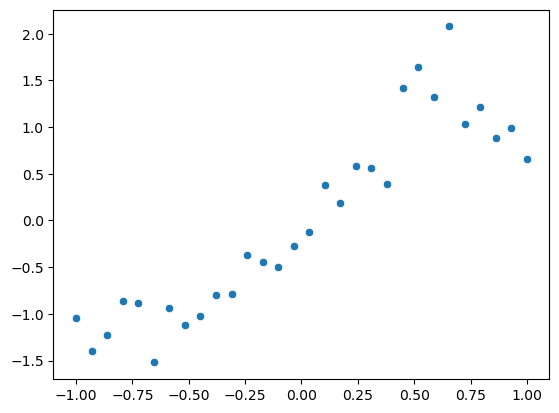

In [2]:
# test data

N = 30
sigma_obs = 0.15
N_test = 400

def y_func(X_pred):
    return(X_pred + 0.2 * jnp.power(X_pred, 2.0) + 0.5 * jnp.power(0.5 + X_pred, 2.0) * jnp.sin(4.0 * X_pred))
    

np.random.seed(0)
X = jnp.linspace(-1, 1, N)
X_pred = jnp.linspace(-1.3, 1.3, N_test)
Y_true = y_func(X_pred)
Y_true -= jnp.mean(Y_true)
Y_true /= jnp.std(Y_true)

Y = y_func(X)
Y += sigma_obs * np.random.randn(N)
Y -= jnp.mean(Y)
Y /= jnp.std(Y)

assert X.shape == (N,)
assert Y.shape == (N,)

sns.scatterplot(x=X,y=Y)


In [3]:
args = {
    'num_samples': 1000,
    'num_warmup': 1000,
    'num_chains': 1,
    'thinning': 2,
    'device': 'cpu',
    'init_strategy': 'median'
}

# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
samples = run_inference(model, args, rng_key, X, Y, X_pred)


sample: 100%|██████████| 2000/2000 [00:01<00:00, 1121.98it/s, 3 steps of size 4.54e-01. acc. prob=0.95] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      0.53      0.17      0.50      0.30      0.83    399.40      1.00
   kernel_noise      0.08      0.02      0.08      0.05      0.12    440.72      1.00
     kernel_var      1.94      2.86      1.06      0.19      4.53    322.62      1.00

Number of divergences: 0

MCMC elapsed time: 4.425791025161743


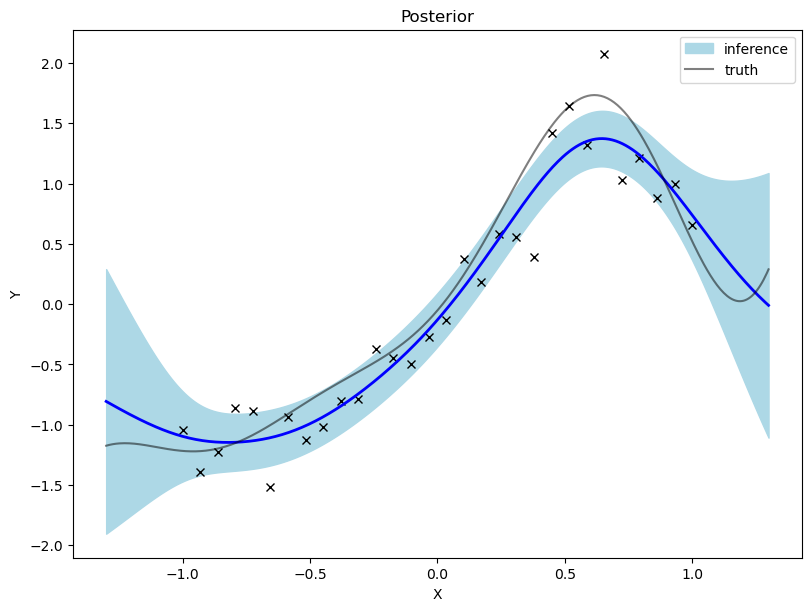

In [4]:
posterior_means = np.mean(samples["pred"][0], axis=0)
vars = np.mean(samples["pred"][1], axis=0) # (maybe sus, TODO: check later)
lower = posterior_means - 2*jnp.sqrt(vars) # 2* std dev ~ 95 CI
upper = posterior_means + 2*jnp.sqrt(vars)

fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(X, Y, "kx")
# plot 90% confidence level of predictions
ax.fill_between(X_pred, lower, upper, color="lightblue", label='inference')
# plot mean prediction
ax.plot(X_pred, posterior_means, "blue", ls="solid", lw=2.0)
# plot truth
ax.plot(X_pred, Y_true, "k", lw=1.5, alpha=0.5, label="truth")
ax.set(xlabel="X", ylabel="Y", title="Posterior")
plt.legend()

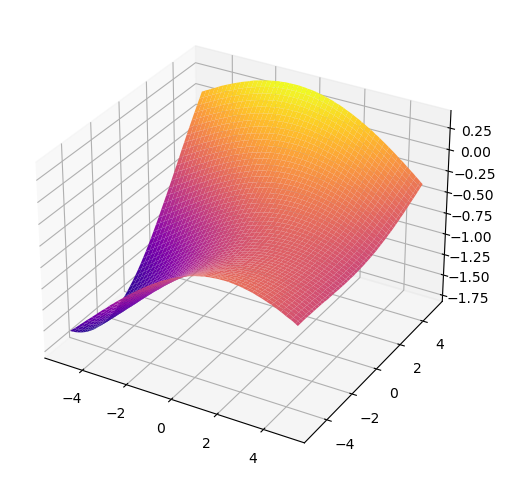

In [9]:
# simulate 2d data from GP

from scipy.stats import multivariate_normal, uniform
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

x_grid, y_grid = jnp.linspace(-5, 5, 100), np.linspace(-5, 5, 50)
x_2d, y_2d = jnp.meshgrid(x_grid, y_grid)
X_true = jnp.vstack((x_2d.flatten(), y_2d.flatten())).T

kernel = 2*kernels.ExpSquared(scale=8)
gp = GaussianProcess(kernel, X_true, diag=1e-6)
Y_true = gp.sample(jax.random.PRNGKey(4), shape=(1,))


fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

Y_reshape = jnp.reshape(Y_true, (50,100))
ax.plot_surface(x_2d, y_2d, Y_reshape, cmap=cm.plasma)

plt.show()

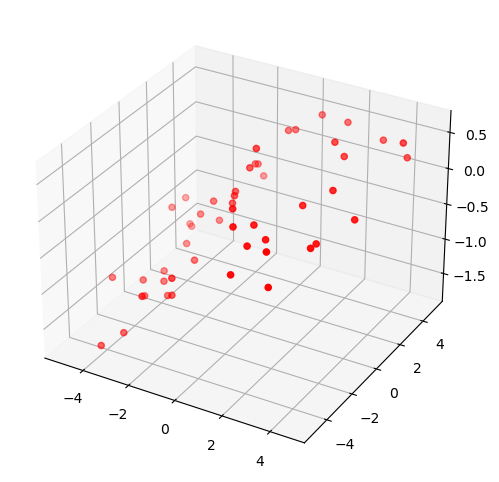

In [21]:
N = 50
sigma_obs = 0.15

np.random.seed(42)
x1_indices = np.random.choice(np.arange(0, x_grid.shape[0]), size=N, replace=False)
x2_indices = np.random.choice(np.arange(0, y_grid.shape[0]), size=N, replace=False)

X = jnp.vstack((x_grid[x1_indices], y_grid[x2_indices])).T
Y = Y_reshape[x1_indices, x2_indices]
Y += sigma_obs * np.random.randn(N)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], Y, c='red')


In [22]:
samples = run_inference(model, args, rng_key, X, Y, X_true)

sample: 100%|██████████| 2000/2000 [00:03<00:00, 550.75it/s, 1 steps of size 5.00e-01. acc. prob=0.94] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      3.09      0.40      3.05      2.45      3.68    405.68      1.00
   kernel_noise      0.02      0.01      0.02      0.01      0.03    467.51      1.00
     kernel_var      0.65      0.38      0.56      0.21      1.11    342.81      1.00

Number of divergences: 0

MCMC elapsed time: 7.0200419425964355


<Figure size 800x600 with 0 Axes>

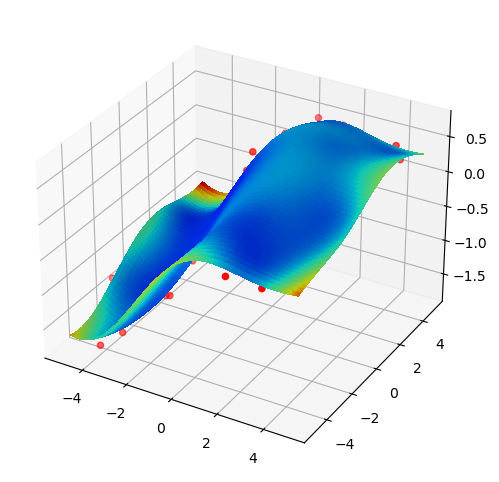

In [23]:
post_means = np.mean(samples["pred"][0], axis=0)
post_vars = np.sqrt(np.mean(samples["pred"][1], axis=0))
post_means.shape

fig = plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')


post_means_reshape = jnp.reshape(post_means, (50,100))
post_vars_reshape = jnp.reshape(post_vars, (50,100))
# ax.plot_surface(x_2d, y_2d, post_means_reshape, cmap=cm.plasma)
ax.plot_surface(x_2d, y_2d, post_means_reshape,rstride=1, cstride=1, facecolors = cm.jet(post_vars_reshape/np.amax(post_vars_reshape)),linewidth=0, antialiased=False)
ax.scatter(X[:,0], X[:,1], Y, c='red')
# ax.view_init(15, -75)

plt.show()

In [24]:
# run on previous data w/ no factors in generative model
args = {
    'num_samples': 1000,
    'num_warmup': 1000,
    'num_chains': 1,
    'thinning': 2,
    'device': 'cpu',
    'init_strategy': 'median'
}

# do inference
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

X_factor = np.tile(np.array([1.0,2.0]), int(X.shape[0]/2))
factors = np.unique(X_factor)
samples = run_inference_anova(anova_model, args, rng_key, X, X_factor, Y, X_true, factors)

sample: 100%|██████████| 2000/2000 [01:59<00:00, 16.79it/s, 31 steps of size 8.93e-03. acc. prob=0.95]  



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
 alpha_1.0[0]     -0.00      0.00     -0.00     -0.01      0.00    353.99      1.00
 alpha_1.0[1]     -0.00      0.00      0.00     -0.00      0.01    380.21      1.00
 alpha_1.0[2]     -0.00      0.00     -0.00     -0.01      0.00    442.89      1.00
 alpha_1.0[3]     -0.00      0.00      0.00     -0.01      0.00    419.87      1.00
 alpha_1.0[4]     -0.00      0.00     -0.00     -0.01      0.01    248.86      1.02
 alpha_1.0[5]      0.00      0.00      0.00     -0.00      0.01    291.07      1.00
 alpha_1.0[6]     -0.00      0.00     -0.00     -0.01      0.01    404.70      1.00
 alpha_1.0[7]     -0.00      0.00     -0.00     -0.00      0.01    484.19      1.00
 alpha_1.0[8]     -0.00      0.00      0.00     -0.00      0.01    301.44      1.00
 alpha_1.0[9]      0.00      0.00      0.00     -0.01      0.01    430.77      1.00
alpha_1.0[10]     -0.00      0.00      0.00     -0.01      0.01    377.53  

<Figure size 800x600 with 0 Axes>

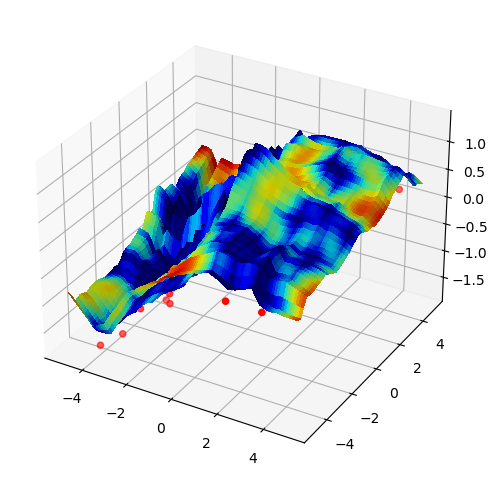

In [25]:
post_means = np.mean(samples["pred"][0], axis=0)
post_vars = np.mean(samples["pred"][1], axis=0)
post_means.shape

fig = plt.figure(figsize=(8,6))
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')


post_means_reshape = jnp.reshape(post_means, (50,100))
post_vars_reshape = jnp.reshape(post_vars, (50,100))
# ax.plot_surface(x_2d, y_2d, post_means_reshape, cmap=cm.plasma)
ax.plot_surface(x_2d, y_2d, post_means_reshape,rstride=1, cstride=1, facecolors = cm.jet(post_vars_reshape/np.amax(post_vars_reshape)),linewidth=0, antialiased=False)
ax.scatter(X[:,0], X[:,1], Y, c='red')
# ax.view_init(15, -75)

plt.show()

In [28]:
# simulate from factor GP w/ 2 cell types

from scipy.stats import multivariate_normal, uniform
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

N_samples = 100
X_factor_true = np.tile(np.array([1.0,2.0]), int(X_true.shape[0]/2))

var_mu = 0.3
var_alpha = 0.2
var_eps = 0.1

mu_kernel = 2*kernels.Matern32(3)
alpha_kernel= 2*kernels.Matern32(2)
eps_kernel =  2*kernels.Matern32(0.5)

Beta_0 = 0.5
mu_gp = GaussianProcess(mu_kernel, X_true, diag=1e-5, mean=Beta_0)
mu = mu_gp.sample(jax.random.PRNGKey(4), shape=(N_samples,))
# mu = numpyro.sample("mu", mu_gp.numpyro_dist())

rho_alpha = 0.5
alpha_kernel = var_alpha*kernels.Matern32(rho_alpha)
rho_eps = 0.2
eps_kernel = var_eps*kernels.Matern32(rho_eps)
for l in factors:
    alpha_gp = GaussianProcess(alpha_kernel, X_true[X_factor_true==l,:], diag=1e-5, mean=0.0)
    alpha_l = alpha_gp.sample(jax.random.PRNGKey(4), shape=(N_samples/2,))
    # alpha_l = numpyro.sample("alpha_"+str(l), alpha_gp.numpyro_dist())
    mu = mu.at[X_factor==l].set(mu[X_factor==l] + alpha_l)

Y_gp = GaussianProcess(eps_kernel, X_true, diag=1e-5, mean_value=mu)
Y_true = Y_gp.sample(jax.random.PRNGKey(4), shape=(N_samples,))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

Y_reshape = jnp.reshape(Y_true, (50,100))
ax.plot_surface(x_2d, y_2d, Y_reshape, cmap=cm.plasma)

plt.show()

TypeError: Shapes must be 1D sequences of concrete values of integer type, got (2500, 50.0).

In [ ]:
rng_key, rng_key_predict = random.split(random.PRNGKey(0))

X_factor = np.tile(np.array([1.0,2.0]), int(X.shape[0]/2))
factors = np.unique(X_factor)
samples = run_inference_anova(anova_model, args, rng_key, X, X_factor, Y, X_true, factors)